In [1]:
# If needed (run once):
# !pip -q install numpy pandas matplotlib requests soundfile librosa

import os
import zipfile
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import soundfile as sf

import librosa
import librosa.display
import matplotlib.pyplot as plt

In [3]:
# ESC-50 dataset URL (ZIP from GitHub)
ESC50_ZIP_URL = "https://github.com/karolpiczak/ESC-50/archive/refs/heads/master.zip"

# Local paths
DATA_DIR = Path("esc50_data")
ZIP_PATH = DATA_DIR / "esc50.zip"
EXTRACT_DIR = DATA_DIR / "extracted"

DATA_DIR.mkdir(parents=True, exist_ok=True)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

print("download to:", ZIP_PATH)
print("extract to:", EXTRACT_DIR)

download to: esc50_data\esc50.zip
extract to: esc50_data\extracted


In [4]:
# Download the ZIP (dataset from URL)
r = requests.get(ESC50_ZIP_URL, stream=True, timeout=120)
r.raise_for_status()

with open(ZIP_PATH, "wb") as f:
    for chunk in r.iter_content(chunk_size=1024 * 1024):
        if chunk:
            f.write(chunk)

print("Downloaded ZIP size (bytes):", ZIP_PATH.stat().st_size)

Downloaded ZIP size (bytes): 645695005


In [5]:
# Extract ZIP
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# The extracted folder name is usually: ESC-50-master
ROOT = next(EXTRACT_DIR.glob("ESC-50-*"))
AUDIO_DIR = ROOT / "audio"
META_CSV = ROOT / "meta" / "esc50.csv"

print("Dataset root:", ROOT)
print("Audio folder exists:", AUDIO_DIR.exists())
print("Metadata file exists:", META_CSV.exists())

Dataset root: esc50_data\extracted\ESC-50-master
Audio folder exists: True
Metadata file exists: True


In [6]:
# esc50.csv contains columns like: filename, fold, target, category, ...
meta = pd.read_csv(META_CSV)

print("Total files in metadata:", len(meta))
print("Columns:", meta.columns.tolist())
print("\nExample rows:")
display(meta.head())

# For a basic lab: process a SMALL subset (e.g., 10 files)
# You can change N to 50/100 later if needed.
N = 10
subset = meta.sample(N, random_state=42).reset_index(drop=True)

print("\nChosen subset classes:", subset["category"].unique())
subset

Total files in metadata: 2000
Columns: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take']

Example rows:


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A



Chosen subset classes: ['clapping' 'pouring_water' 'train' 'sneezing' 'clock_alarm' 'engine'
 'crying_baby' 'crackling_fire']


,filename,fold,target,category,esc10,src_file,take
0,5-221950-A-22.wav,5,22,clapping,False,221950,A
1,1-79220-A-17.wav,1,17,pouring_water,False,79220,A
2,4-165845-A-45.wav,4,45,train,False,165845,A
3,3-130330-A-22.wav,3,22,clapping,False,130330,A
4,4-157297-A-21.wav,4,21,sneezing,True,157297,A
5,4-151242-A-37.wav,4,37,clock_alarm,False,151242,A
6,3-141240-A-44.wav,3,44,engine,False,141240,A
7,5-198411-D-20.wav,5,20,crying_baby,True,198411,D
8,1-17742-A-12.wav,1,12,crackling_fire,True,17742,A
9,4-164661-A-12.wav,4,12,crackling_fire,True,164661,A


In [7]:
# Pick one sample to explain digitalization clearly
row = subset.iloc[0]
wav_path = AUDIO_DIR / row["filename"]

# Load WAV into numerical samples (digital signal)
signal, sr = sf.read(wav_path)

# Convert stereo -> mono if needed
if signal.ndim == 2:
    signal = signal.mean(axis=1)

# Normalize to [-1, 1] (good practice)
signal = signal.astype(np.float32)
signal = signal / (np.max(np.abs(signal)) + 1e-12)

print("File:", row["filename"])
print("Category:", row["category"])
print("Sampling rate (Hz):", sr)
print("Number of samples:", len(signal))
print("Duration (sec):", len(signal)/sr)

print("\nFirst 30 digital samples (this is the digitalized vector):")
print(signal[:30])

File: 5-221950-A-22.wav
Category: clapping
Sampling rate (Hz): 44100
Number of samples: 220500
Duration (sec): 5.0

First 30 digital samples (this is the digitalized vector):
[0.00185102 0.00185102 0.0017872  0.00185102 0.00217017 0.00255314
 0.00255314 0.00255314 0.00261697 0.00280845 0.00287228 0.00293611
 0.00319142 0.00351056 0.00363822 0.00395736 0.00395736 0.00357439
 0.00357439 0.00395736 0.00414885 0.00408502 0.00395736 0.00370205
 0.00344674 0.00312759 0.00274462 0.00255314 0.00261697 0.00248931]


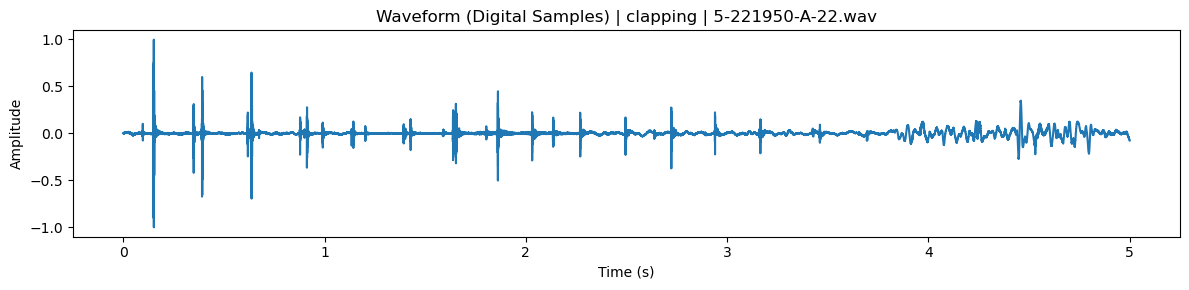

In [8]:
t = np.arange(len(signal)) / sr

plt.figure(figsize=(12, 3))
plt.plot(t, signal)
plt.title(f"Waveform (Digital Samples) | {row['category']} | {row['filename']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

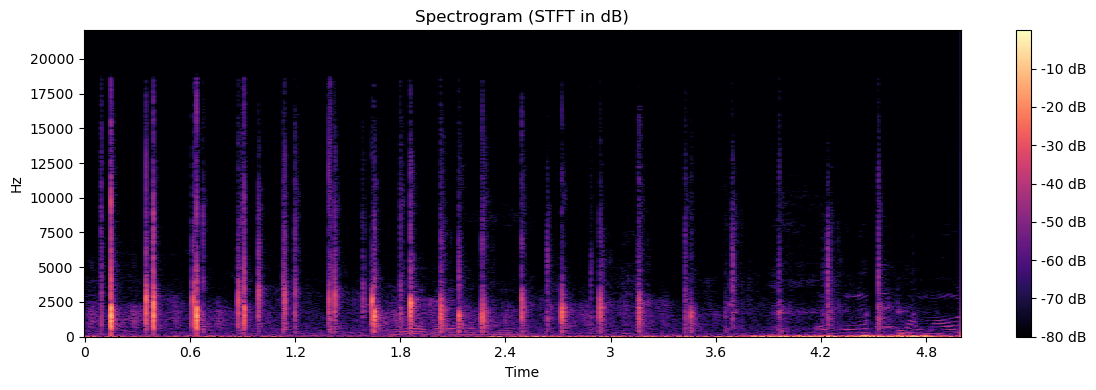

In [9]:
# STFT -> magnitude -> dB
S = np.abs(librosa.stft(signal, n_fft=2048, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (STFT in dB)")
plt.tight_layout()
plt.show()

In [10]:
# MFCC matrix: (n_mfcc, frames)
n_mfcc = 13
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

# Convert MFCC matrix -> fixed-length dense vector using summary stats
mfcc_mean = mfcc.mean(axis=1)   # (13,)
mfcc_std  = mfcc.std(axis=1)    # (13,)

dense_mfcc = np.concatenate([mfcc_mean, mfcc_std])  # (26,)

print("MFCC shape (n_mfcc, frames):", mfcc.shape)
print("Dense MFCC vector length:", len(dense_mfcc))

print("\nDense MFCC vector values:")
print(dense_mfcc)

MFCC shape (n_mfcc, frames): (13, 431)
Dense MFCC vector length: 26

Dense MFCC vector values:
[-418.4199     113.09798     -4.792469    -4.6206665    8.006509
   19.470503     8.328732     6.477856     5.9047465    8.093856
    7.978563     7.9397492    5.1761675   92.26425     18.790028
   39.06643     19.016914    17.267275     9.548351    13.146371
    7.9863524    9.696406     7.9676166   10.057893     6.413425
    6.7444396]


In [11]:
# Feature names for MFCC mean/std
mfcc_feature_names = [f"mfcc_{i+1}_mean" for i in range(n_mfcc)] + [f"mfcc_{i+1}_std" for i in range(n_mfcc)]

# Extra features (frame-wise -> summarize to mean/std)
rms = librosa.feature.rms(y=signal)[0]
zcr = librosa.feature.zero_crossing_rate(signal)[0]
centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]

extra_vals = np.array([
    rms.mean(), rms.std(),
    zcr.mean(), zcr.std(),
    centroid.mean(), centroid.std()
], dtype=np.float32)

extra_names = [
    "rms_mean", "rms_std",
    "zcr_mean", "zcr_std",
    "centroid_mean", "centroid_std"
]

final_vector = np.concatenate([dense_mfcc, extra_vals])
final_names = mfcc_feature_names + extra_names

print("Final dense vector length:", len(final_vector))
print("\nFeature Names + Values:")
for name, val in zip(final_names, final_vector):
    print(f"{name:15s} : {val: .6f}")

Final dense vector length: 32

Feature Names + Values:
mfcc_1_mean     : -418.419891
mfcc_2_mean     :  113.097977
mfcc_3_mean     : -4.792469
mfcc_4_mean     : -4.620667
mfcc_5_mean     :  8.006509
mfcc_6_mean     :  19.470503
mfcc_7_mean     :  8.328732
mfcc_8_mean     :  6.477856
mfcc_9_mean     :  5.904747
mfcc_10_mean    :  8.093856
mfcc_11_mean    :  7.978563
mfcc_12_mean    :  7.939749
mfcc_13_mean    :  5.176167
mfcc_1_std      :  92.264252
mfcc_2_std      :  18.790028
mfcc_3_std      :  39.066429
mfcc_4_std      :  19.016914
mfcc_5_std      :  17.267275
mfcc_6_std      :  9.548351
mfcc_7_std      :  13.146371
mfcc_8_std      :  7.986352
mfcc_9_std      :  9.696406
mfcc_10_std     :  7.967617
mfcc_11_std     :  10.057893
mfcc_12_std     :  6.413425
mfcc_13_std     :  6.744440
rms_mean        :  0.024690
rms_std         :  0.027474
zcr_mean        :  0.027540
zcr_std         :  0.027293
centroid_mean   :  1860.349854
centroid_std    :  1056.251831


In [12]:
# For each audio file in subset:
# audio -> digital samples -> MFCC + extras -> one dense vector row
rows = []

for _, r in subset.iterrows():
    wav_path = AUDIO_DIR / r["filename"]
    x, sr = sf.read(wav_path)
    if x.ndim == 2:
        x = x.mean(axis=1)
    x = x.astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-12)

    # MFCC
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std  = mfcc.std(axis=1)
    dense_mfcc = np.concatenate([mfcc_mean, mfcc_std])

    # Extras
    rms = librosa.feature.rms(y=x)[0]
    zcr = librosa.feature.zero_crossing_rate(x)[0]
    centroid = librosa.feature.spectral_centroid(y=x, sr=sr)[0]

    extra_vals = np.array([
        rms.mean(), rms.std(),
        zcr.mean(), zcr.std(),
        centroid.mean(), centroid.std()
    ], dtype=np.float32)

    feat_vec = np.concatenate([dense_mfcc, extra_vals])

    rows.append({
        "filename": r["filename"],
        "category": r["category"],
        **{name: float(val) for name, val in zip(final_names, feat_vec)}
    })

features_df = pd.DataFrame(rows)

print("Feature table shape:", features_df.shape)
display(features_df.head())

# Save to CSV (optional)
out_csv = DATA_DIR / "esc50_features_subset.csv"
features_df.to_csv(out_csv, index=False)
print("Saved features CSV to:", out_csv)

Feature table shape: (10, 34)


,filename,category,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,...,mfcc_10_std,mfcc_11_std,mfcc_12_std,mfcc_13_std,rms_mean,rms_std,zcr_mean,zcr_std,centroid_mean,centroid_std
0,5-221950-A-22.wav,clapping,-418.419891,113.097977,-4.792469,-4.620667,8.006509,19.470503,8.328732,6.477856,...,7.967617,10.057893,6.413425,6.744440,0.024690,0.027474,0.027540,0.027293,1860.349854,1056.251831
1,1-79220-A-17.wav,pouring_water,-281.806641,26.128155,-8.161149,17.039577,2.703290,22.813492,5.602521,22.619160,...,11.515883,9.074911,8.081208,7.549473,0.120141,0.122125,0.068106,0.080860,4369.639160,3173.564697
2,4-165845-A-45.wav,train,-126.570229,184.926178,-22.379425,47.136391,-2.880022,12.862853,-13.928845,2.384974,...,6.088831,7.049892,6.498786,5.865864,0.204336,0.094168,0.034948,0.015140,1770.874512,524.290161
3,3-130330-A-22.wav,clapping,-234.434875,51.610542,-46.947983,13.478400,-22.553028,-2.323793,-6.163353,-4.842568,...,8.415661,6.858360,9.777322,6.072386,0.184421,0.218635,0.154528,0.117418,4491.356445,2949.135498
4,4-157297-A-21.wav,sneezing,-457.258331,50.195438,-7.313574,8.269366,2.596452,15.479823,-0.085230,0.503247,...,10.736309,12.435872,10.930223,8.521382,0.038525,0.067301,0.281095,0.300483,7774.246094,5727.419922


Saved features CSV to: esc50_data\esc50_features_subset.csv
